In [56]:
import tensorflow as tf
from tensorflow import keras

from nn import datasets, models
from hstar import gghzz, c6, msq
from hzz import zpair, angles

import numpy as np
import matplotlib.pyplot as plt

import json, os

from sklearn.preprocessing import StandardScaler

In [57]:
SEED=373485

JOBS_DIR='jobs/'
CONFIG_FILE=JOBS_DIR + 'train-single-SIG/job.config'

In [58]:
config=None
scaler_config=None

with open(CONFIG_FILE, 'r') as config_file:
    config, scaler_config  = json.loads(''.join(config_file.readlines()))

print(config)

{'sample_dir': '../..', 'output_dir': 'train-single-SIG', 'learning_rate': 1e-05, 'batch_size': 32, 'sig': True, 'int': False, 'num_events': 300000, 'num_layers': 10, 'num_nodes': 2000, 'epochs': 100, 'c6_values': [-10.0]}


In [59]:
sample = gghzz.Process(  
    (1.4783394, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ2e2m_all_new.csv'), 110000),
    (0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4e_all_new.csv'), 110000),
    (0.47412769, os.path.join(JOBS_DIR, config['sample_dir'], 'ggZZ4m_all_new.csv'), 110000)
)

sample.events = sample.events[300000:]

In [60]:
z_chooser = zpair.ZPairChooser(bounds1=(50,115), bounds2=(50,115), algorithm='leastsquare')
l1_1, l2_1, l1_2, l2_2 = sample.events.filter(z_chooser)

kin_variables = angles.calculate(l1_1, l2_1, l1_2, l2_2)

print(kin_variables.shape)

c6_values = np.array(config['c6_values'])

component = msq.Component.SIG if config['sig'] else msq.Component.SBI
component = msq.Component.INT if config['int'] else component

c6_mod = c6.Modifier(amplitude_component = component, c6_values = [-5,-1,0,1,5])
c6_weights, c6_prob = c6_mod.modify(sample=sample, c6=c6_values)

(28939, 8)


In [61]:
data = []

signal_weights = c6_prob
background_weights = tf.convert_to_tensor(sample[component].probabilities)[:,tf.newaxis]

for i in range(len(c6_values)):
    param = c6_values[i]

    sig_weights = tf.cast(signal_weights.T[i][:,tf.newaxis], tf.float32)
    bkg_weights = tf.cast(background_weights, tf.float32)

    data.append(tf.concat([kin_variables, tf.ones(kin_variables.shape[0])[:,tf.newaxis]*param, sig_weights, bkg_weights], axis=1))

test_data = tf.reshape(tf.convert_to_tensor(data), (tf.convert_to_tensor(data).shape[0]*tf.convert_to_tensor(data).shape[1], tf.convert_to_tensor(data).shape[2]))

print(test_data)

tf.Tensor(
[[-9.7876954e-01  9.9396038e-01 -4.4383126e-01 ... -1.0000000e+01
   5.6635432e-05  7.9650017e-05]
 [ 9.8542541e-01  9.5558125e-01  9.8806643e-01 ... -1.0000000e+01
   5.7340844e-06  7.7944342e-06]
 [ 9.9780500e-01  9.9881095e-01  9.9949878e-01 ... -1.0000000e+01
   6.6487855e-06  9.0747608e-06]
 ...
 [ 9.3632948e-01  9.9856299e-01  9.8994863e-01 ... -1.0000000e+01
   2.9183331e-05  3.7272715e-05]
 [ 9.9541140e-01  9.2538452e-01 -3.0904735e-02 ... -1.0000000e+01
   4.9609612e-06  7.0028077e-06]
 [-9.2910779e-01  9.7728360e-01  5.0628078e-01 ... -1.0000000e+01
   8.3348559e-06  1.8987044e-05]], shape=(28939, 11), dtype=float32)


In [62]:
scaler = StandardScaler()

scaler.mean_ = scaler_config['scaler.mean_']
scaler.var_ = scaler_config['scaler.var_']
scaler.scale_ = scaler_config['scaler.scale_']

test_data = tf.concat([scaler.transform(test_data[:,:8]), test_data[:,8:]], axis=1)

print(test_data, test_data.shape)

mu = tf.reduce_sum(test_data[:,:8], axis=0)/test_data.shape[0]

print('Mean (after):', mu)

sigma = tf.math.reduce_std(test_data[:,:8], axis=0)

print('sigma (after):', sigma)

tf.Tensor(
[[-1.1405703e+00  6.0113078e-01 -1.9725319e+00 ... -1.0000000e+01
   5.6635432e-05  7.9650017e-05]
 [ 1.1253510e+00  5.3229600e-01  5.9087509e-01 ... -1.0000000e+01
   5.7340844e-06  7.7944342e-06]
 [ 1.1396322e+00  6.0983050e-01  6.1134148e-01 ... -1.0000000e+01
   6.6487855e-06  9.0747608e-06]
 ...
 [ 1.0687132e+00  6.0938579e-01  5.9424460e-01 ... -1.0000000e+01
   2.9183331e-05  3.7272715e-05]
 [ 1.1368709e+00  4.7813672e-01 -1.2333040e+00 ... -1.0000000e+01
   4.9609612e-06  7.0028077e-06]
 [-1.0832798e+00  5.7122016e-01 -2.7162558e-01 ... -1.0000000e+01
   8.3348559e-06  1.8987044e-05]], shape=(28939, 11), dtype=float32) (28939, 11)
Mean (after): tf.Tensor(
[ 0.05019721  0.02693132  0.03724584  0.00403767  0.00163413  0.0570847
  0.07696905 -0.03392626], shape=(8,), dtype=float32)
sigma (after): tf.Tensor(
[1.0105765  0.98614776 0.9788071  1.0009581  1.0117391  1.1372657
 1.1361985  0.9400576 ], shape=(8,), dtype=float32)


In [63]:
model = keras.models.load_model(os.path.join(JOBS_DIR, config['output_dir'], 'checkpoint.model.tf'), custom_objects={'C6_4l_clf': models.C6_4l_clf, 'swish_activation': models.swish_activation})

In [64]:
data = test_data[:,:8][:,np.newaxis]

print(data)
predictions = model.predict(data, verbose=1)

real_ratios = test_data[:,9]/test_data[:,10]

predictions = tf.convert_to_tensor(predictions)

ratios = tf.squeeze(predictions/(1-predictions), axis=2)

print(ratios, tf.math.reduce_min(ratios), tf.math.reduce_max(ratios))

real_ratios = tf.convert_to_tensor(real_ratios)

print(real_ratios, tf.math.reduce_min(real_ratios), tf.math.reduce_max(real_ratios))

real = real_ratios.numpy()
pred = ratios.numpy()

tf.Tensor(
[[[-1.1405703   0.6011308  -1.9725319  ... -0.19738711 -0.14053638
    0.2606324 ]]

 [[ 1.125351    0.532296    0.5908751  ...  0.675365    0.53871626
   -0.7314046 ]]

 [[ 1.1396322   0.6098305   0.6113415  ...  1.792694    1.031374
   -0.69999   ]]

 ...

 [[ 1.0687132   0.6093858   0.5942446  ...  0.85329676 -0.17972746
    0.3864597 ]]

 [[ 1.1368709   0.47813672 -1.233304   ... -0.41790333  0.49009347
   -0.60064846]]

 [[-1.0832798   0.57122016 -0.27162558 ...  0.09000755 -0.12272044
   -0.15568152]]], shape=(28939, 1, 8), dtype=float32)
905/905 [==============================] - 199s 219ms/step
tf.Tensor(
[[0.6732926 ]
 [0.69362   ]
 [0.6632827 ]
 ...
 [0.70097756]
 [0.5844347 ]
 [0.61546457]], shape=(28939, 1), dtype=float32) tf.Tensor(0.41497788, shape=(), dtype=float32) tf.Tensor(1.2633058, shape=(), dtype=float32)
tf.Tensor([0.7110536  0.73566395 0.73266786 ... 0.7829677  0.70842457 0.43897596], shape=(28939,), dtype=float32) tf.Tensor(0.36778384, shape=(), dtype

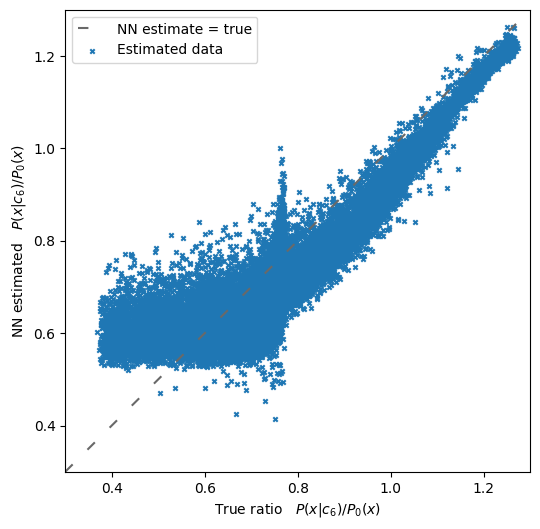

In [65]:
lnspc = np.linspace(0.3,1.3)

plt.figure(figsize=(6,6))

plt.plot(lnspc, lnspc, color='dimgray', linestyle=(0,(5,10)), label='NN estimate = true')
plt.scatter(real, pred, s=10, marker='x', label=f'Estimated data')
plt.xlabel(u'True ratio   $P(x|c_6)/P_0(x)$')
plt.ylabel(u'NN estimated   $P(x|c_6)/P_0(x)$')
plt.xlim(0.3,1.3)
plt.ylim(0.3,1.3)
plt.legend()

plt.show()

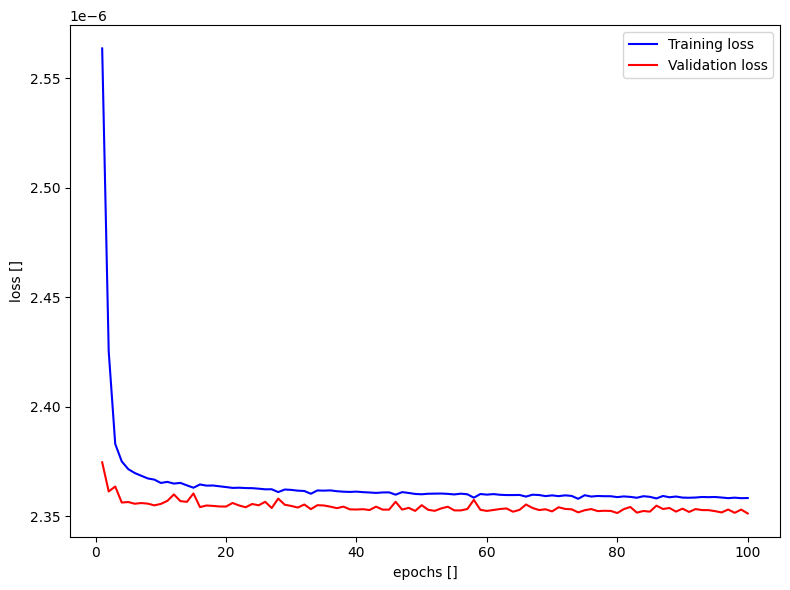

In [66]:
hist_prm = ''

with open(os.path.join(JOBS_DIR, config['output_dir'], 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()